Chapter 1 - Multinomial BNs - Learning BNs from Data

Train Survey

- Age - young, adult, old 
- Sex - male, female 
- Education - high (high-school), university degree 
- Occupation - emp (employee), self-employed (self) 
- Residence - city size: small, big 
- Transportation - car, train, other

In [2]:
install.packages(
  "bnlearn",
  repos = "https://cloud.r-project.org",   # CRAN mirror
  dependencies = TRUE                      # pulls in igraph, gRain, etc.
)
library(bnlearn)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“dependencies ‘graph’, ‘Rgraphviz’ are not available”
also installing the dependencies ‘RcppEigen’, ‘RcppArmadillo’, ‘igraph’, ‘gRbase’, ‘gRain’, ‘Rmpfr’, ‘gmp’


Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘gmp’ had non-zero exit status”
Warning message in install.packages("bnlearn", repos = "https://cloud.r-project.org", :
“installation of package ‘Rmpfr’ had non-zero exit status”


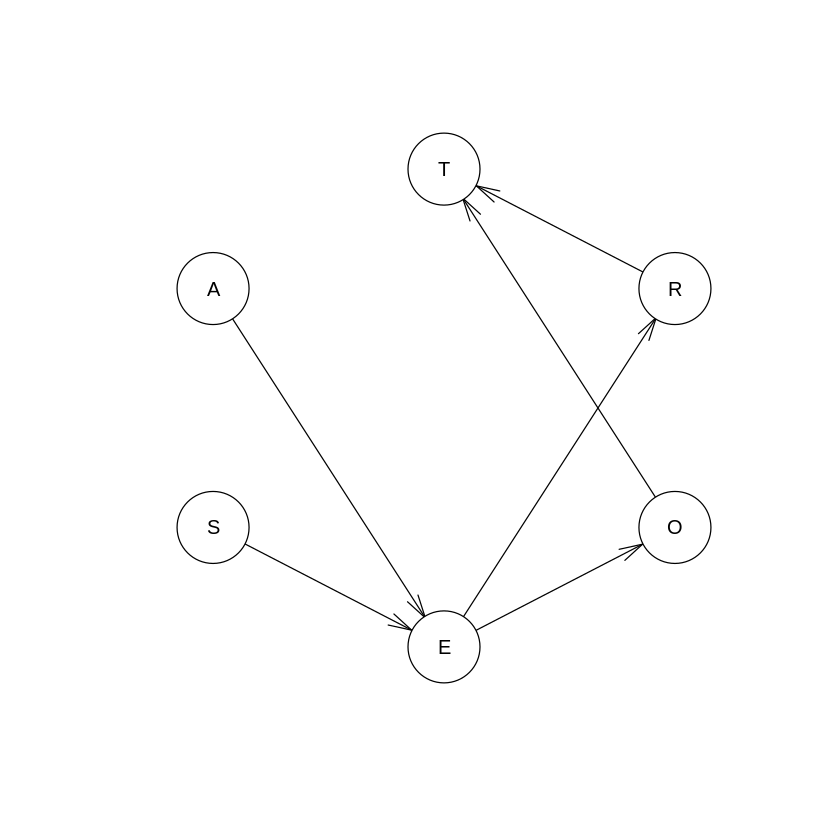

In [4]:
# clear the memory
rm(list = ls())

# set the directory
setwd("/content")

# create an empty graph
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

# Add in the edges
dag <- set.arc(dag, from = "A", to = "E") # age influences education
dag <- set.arc(dag, from = "S", to = "E") # sex influences education
dag <- set.arc(dag, from = "E", to = "O") # ....
dag <- set.arc(dag, from = "E", to = "R") # ....
dag <- set.arc(dag, from = "O", to = "T") # ....
dag <- set.arc(dag, from = "R", to = "T") # ....

plot(dag)

# Read in the data
survey <- read.table("survey.txt", header = TRUE, colClasses = "factor")

## Tests for conditional independence

In [5]:
?ci.test

In [6]:
# H0 (null hypothesis): T and E are conditionally independent given ("O", "R") --> NO edge
# HA (alternative hypothesis): T and E are not independent given ("O", "R") --> edge

# Test 1 -- see if an edge should be there (E->T): check if T & E are conditionally indeppendent given O & R (T's parents)
# Mutual Independence - test
ci.test("T", "E", c("O", "R"), test = "mi", data = survey)


	Mutual Information (disc.)

data:  T ~ E | O + R
mi = 9.8836, df = 8, p-value = 0.2733
alternative hypothesis: true value is greater than 0


In [7]:
# Another way to do above is use Chi-Squared - test
ci.test("T", "E", c("O", "R"), test = "x2", data = survey)

# overall, there is no evidence for an edge. and that's right 'cause in our original network we don't have one as per the real world knowledge of experts


	Pearson's X^2

data:  T ~ E | O + R
x2 = 8.2375, df = 8, p-value = 0.4106
alternative hypothesis: true value is greater than 0


We can also use the same paradigm to see if an edge should be removed. Here, let's check if the edge from O->T should be removed (given R).

In [8]:
# Conditional Independence Tests -- arc should stay
# (O -> T) not much evidence for an edge
ci.test("T", "O", "R", test = "x2", data = survey)


	Pearson's X^2

data:  T ~ O | R
x2 = 3.7988, df = 4, p-value = 0.4339
alternative hypothesis: true value is greater than 0


| Test (code line)                                                 | Conditioning set | **H0 (null)**                                                  | **HA (alt.)**                                                  | *p*-value (≈) | Decision at α = 0.05                                    | Graphical implication                                                                                         |
| ---------------------------------------------------------------- | ---------------- | -------------------------------------------------------------- | -------------------------------------------------------------- | ------------- | ------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| `ci.test("T","E", c("O","R"), test="mi")` <br>Mutual-Information | {O,R}            | T ⫫ E \| {O,R} <br>(T and E are **conditionally independent**) | T \¬⫫ E \| {O,R} <br>(T and E are **conditionally dependent**) | 0.273         | **Fail to reject H0** (no evidence of dependence)       | **NO direct edge** between T and E (when O and R are parents of T)                                            |
| `ci.test("T","E", c("O","R"), test="x2")` <br>χ² version         | {O,R}            | same as above                                                  | same as above                                                  | 0.411         | **Fail to reject H0**                                   | Confirms: still **no T — E edge**                                                                             |
| `ci.test("T","O", "R", test="x2")` <br>Checking arc O → T        | {R}              | T ⫫ O \| R                                                     | T \¬⫫ O \| R                                                   | 0.434         | **Fail to reject H0** (data do **not** show dependence) | **Statistically, the edge O → T is not supported**; one could remove it unless prior knowledge says otherwise |


In [9]:
# Use a DAG to determine arc strength over all edges
arc.strength(dag, data = survey, criterion = "x2") # criterion is chi squared

,from,to,strength
,<chr>,<chr>,<dbl>
1,A,E,0.0009777168
2,S,E,0.0012537013
3,E,O,0.0026379469
4,E,R,0.0005599201
5,O,T,0.4339127237
6,R,T,0.0013584250


All of these edges have p-values lesser than 0.05 so pretty good evidence that we have support for those edges with the exception of O->T(: not a super strong edge, we might consider removing it)

## Learn the Full Network Structure from Data

In [10]:
# examine scores
set.seed(123) # reproducing our output
score(dag, data = survey, type = "bic") # BIC-Bayesian Information Criteria
score(dag, data = survey, type = "bde", iss = 10) # BDE-Bayesian Dirichlet Equivalent
score(dag, data = survey, type = "bde", iss = 1) # BDE

[1] -2012.687

[1] -1998.284

[1] -2015.647

In [11]:
# make a change in the network and re-examine the scores
dag4 <- set.arc(dag, from = "E", to = "T")
score(dag4, data = survey, type = "bic") # no improvement - as expected

[1] -2032.603

In [21]:
# examine the score of a random graph - just for comparison
# (no informatoin in the graph)
rnd <- random.graph(nodes = c("A", "S", "E", "O", "R", "T"))

In [19]:
modelstring(rnd) # it is a BN but not in support of the data, unless it happens by chance

[1] "[A][S][E|A][O|E][R|S:E:O][T|S:O:R]"

In [22]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

In [20]:
score(rnd, data = survey, type = "bic")

[1] -2044.924

In [15]:
# With the hill-climbing algorithm, we can build the score based graph
learned <- hc(survey)
learned


  Bayesian network learned via Score-based methods

  model:
   [R][E|R][T|R][A|E][O|E][S|E] 
  nodes:                                 6 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           1.67 
  average neighbourhood size:            1.67 
  average branching factor:              0.83 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              3.107304 
  tests used in the learning procedure:  40 
  optimized:                             TRUE 


In [23]:
# Examine closer - the network
modelstring(learned)
modelstring(dag)

[1] "[R][E|R][T|R][A|E][O|E][S|E]"

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

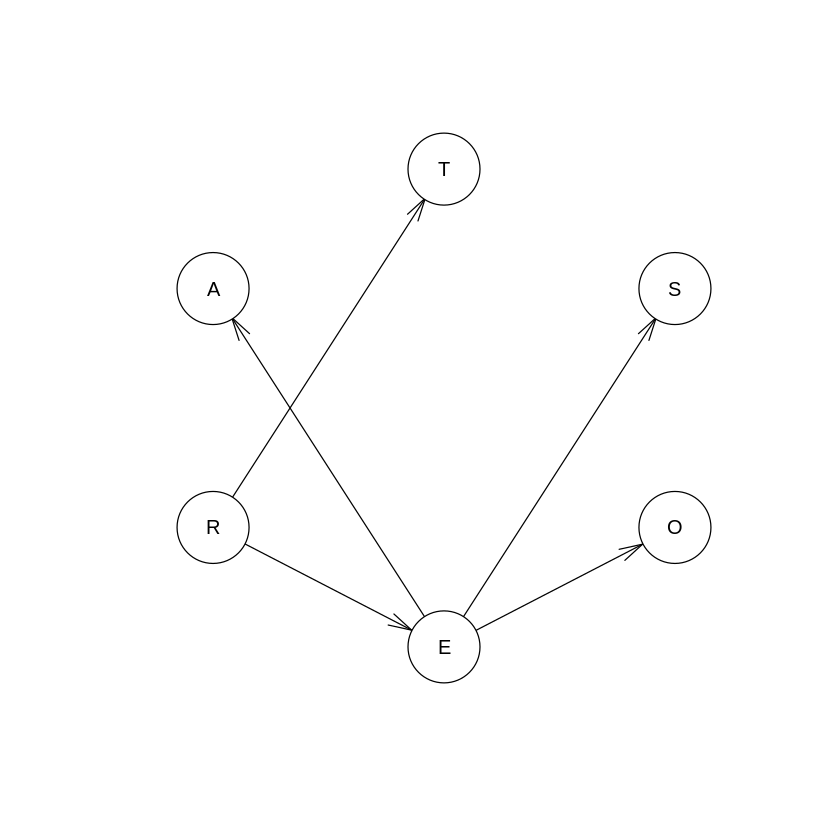

In [24]:
plot(learned)

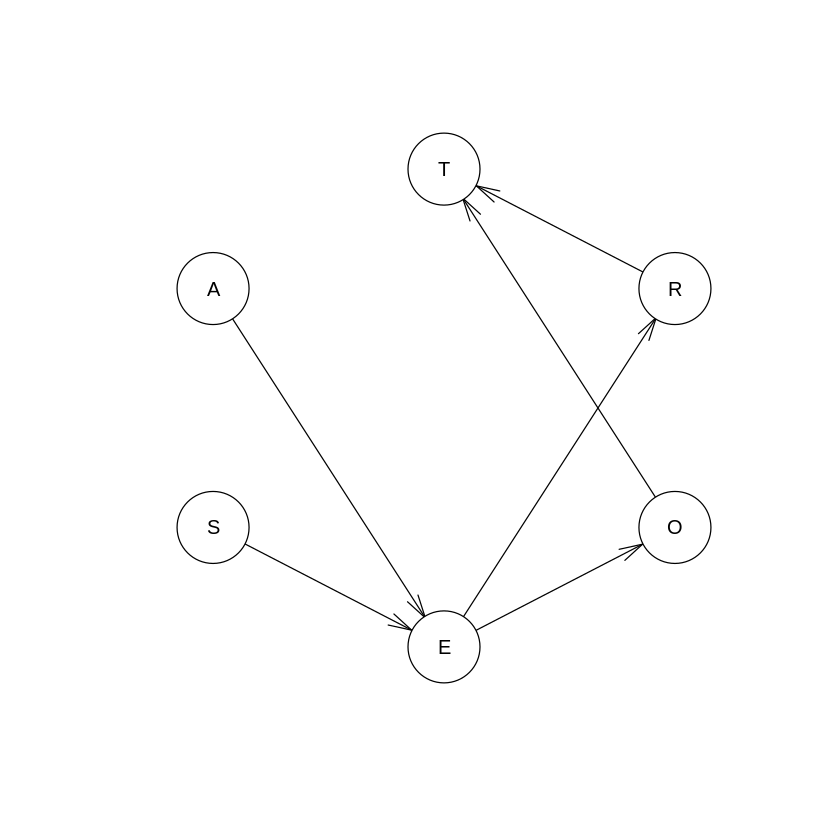

In [25]:
plot(dag)

In [26]:
score(learned, data = survey, type = "bic")
score(dag, data = survey, type = "bic")

[1] -1998.432

[1] -2012.687

In [27]:
# deeper look at the networks and strengths
arc.strength(learned, data = survey, criterion = "bic")

,from,to,strength
,<chr>,<chr>,<dbl>
1,R,E,-3.3896261
2,E,S,-2.7260640
3,R,T,-1.8484171
4,E,A,-1.7195441
5,E,O,-0.8266937


In [28]:
arc.strength(dag, data = survey, criterion = "bic")

,from,to,strength
,<chr>,<chr>,<dbl>
1,A,E,2.4889383
2,S,E,1.4824183
3,E,O,-0.8266937
4,E,R,-3.3896261
5,O,T,10.0457874
6,R,T,2.9734338
